In [1]:
import argparse
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

from utils.image_reader import ImageReader
from tqdm import trange
from utils.config import Config
from model import ICNet, ICNet_BN

# Setup configurations

In [2]:
model_config = {'train': ICNet, 'trainval': ICNet, 'train_bn': ICNet_BN, 'trainval_bn': ICNet_BN, 'others': ICNet_BN}

# Choose dataset here, but remember to use `script/downlaod_weight.py` first
dataset = 'culane'
filter_scale = 1
    
class InferenceConfig(Config):
    def __init__(self, dataset, is_training, filter_scale):
        Config.__init__(self, dataset, is_training, filter_scale)
    
    # You can choose different model here, see "model_config" dictionary. If you choose "others", 
    # it means that you use self-trained model, you need to change "filter_scale" to 2.
    model_type = 'others'

    # Set pre-trained weights here (You can download weight from Google Drive) 
    model_weight = './snapshots/model.ckpt-8500'
    
    # Define default input size here
    INFER_SIZE = (1024, 2048, 3)
                  
cfg = InferenceConfig(dataset, is_training=False, filter_scale=filter_scale)
# cfg.display()


# model_config = {'train': ICNet, 'trainval': ICNet, 'train_bn': ICNet_BN, 'trainval_bn': ICNet_BN, 'others': ICNet_BN}
# dataset = 'culane'
# filter_scale = 1
# model = "others"
# model_weight = './snapshots/model.ckpt-60000'
# INFER_SIZE = (1024, 2048, 3)

# cfg = Config(dataset=dataset, is_training=False, filter_scale=filter_scale)


Setup configurations...


# Create graph, session, and restore weights

In [3]:
# Create graph here 
model = model_config[cfg.model_type]
net = model(cfg=cfg, mode='inference')

# Create session & restore weights!
net.create_session()
net.restore(cfg.model_weight)


# model = model_config[model]
# net = model(cfg=cfg, mode='inference')

# net.create_session()
# net.restore(model_weight)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./snapshots/model.ckpt-8500
Restore from ./snapshots/model.ckpt-8500


# Run segmentation on single image

[0.]


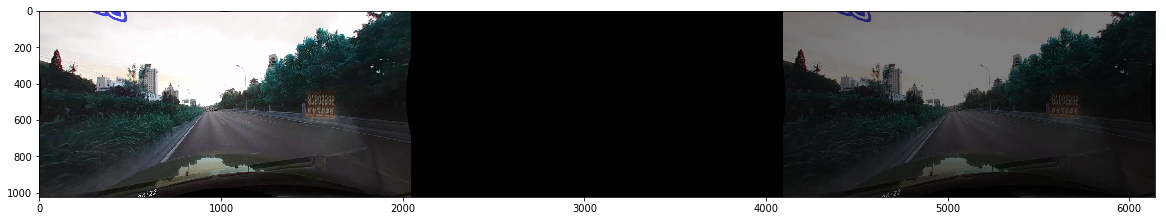

In [4]:
im1 = cv2.imread('./data/input/6.jpg')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

results1 = net.predict(im1)
# results1[0][np.where((results1[0] == [0,0,0]).all(axis = 2))] = [255,255,255]
# results1[0][np.where((results1[0] == [1,1,1]).all(axis = 2))] = [255,255,0]
# results1[0][np.where((results1[0] == [2,2,2]).all(axis = 2))] = [255,0,0]
# results1[0][np.where((results1[0] == [3,3,3]).all(axis = 2))] = [0,255,0]
# results1[0][np.where((results1[0] == [4,4,4]).all(axis = 2))] = [0,0,255]

print(np.unique(results1))

overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

[0.]


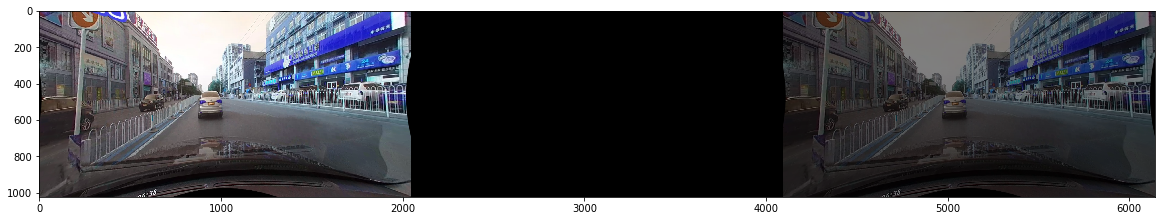

In [5]:
im1 = cv2.imread('./data/input/00095.jpg')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

results1 = net.predict(im1)
# results1[0][np.where((results1[0] == [1,1,1]).all(axis = 2))] = [255,255,0]
# results1[0][np.where((results1[0] == [2,2,2]).all(axis = 2))] = [255,0,0]
# results1[0][np.where((results1[0] == [3,3,3]).all(axis = 2))] = [0,255,0]
# results1[0][np.where((results1[0] == [4,4,4]).all(axis = 2))] = [0,0,255]

print(np.unique(results1))

overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

[0.]


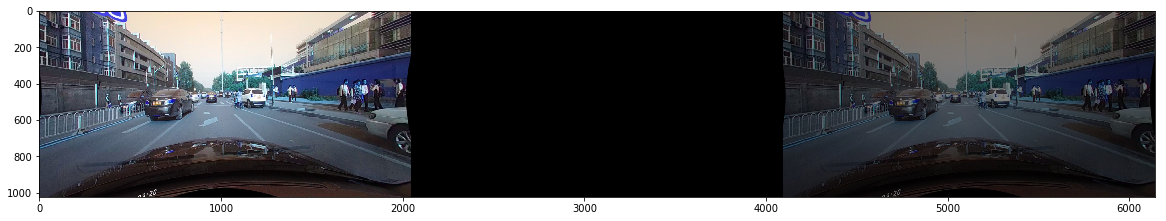

In [6]:
im1 = cv2.imread('./data/input/00120.jpg')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

# results1 = net.predict(im1)
# results1[0][np.where((results1[0] == [1,1,1]).all(axis = 2))] = [255,255,0]
# results1[0][np.where((results1[0] == [2,2,2]).all(axis = 2))] = [255,0,0]
# results1[0][np.where((results1[0] == [3,3,3]).all(axis = 2))] = [0,255,0]
# results1[0][np.where((results1[0] == [4,4,4]).all(axis = 2))] = [0,0,255]

print(np.unique(results1))

overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

[0.]


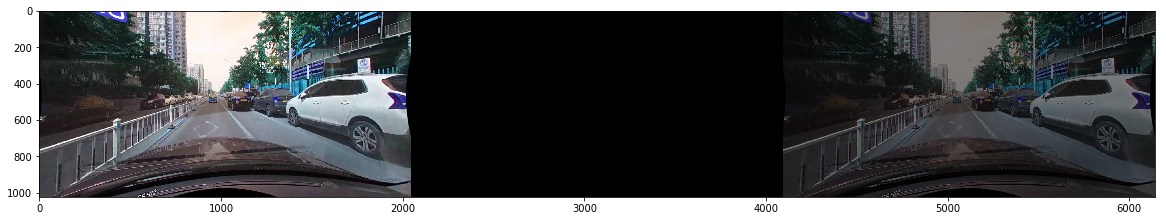

In [7]:
im1 = cv2.imread('./data/input/00150.jpg')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

results1 = net.predict(im1)
# results1[0][np.where((results1[0] == [1,1,1]).all(axis = 2))] = [255,255,0]
# results1[0][np.where((results1[0] == [2,2,2]).all(axis = 2))] = [255,0,0]
# results1[0][np.where((results1[0] == [3,3,3]).all(axis = 2))] = [0,255,0]
# results1[0][np.where((results1[0] == [4,4,4]).all(axis = 2))] = [0,0,255]

print(np.unique(results1))

overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

[0.]


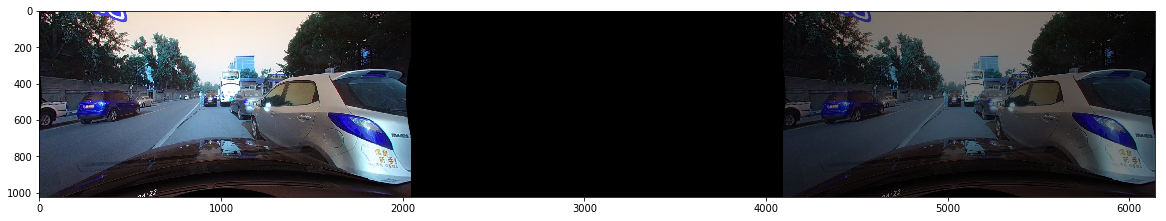

In [8]:
im1 = cv2.imread('./data/input/01980.jpg')

if im1.shape != cfg.INFER_SIZE:
    im1 = cv2.resize(im1, (cfg.INFER_SIZE[1], cfg.INFER_SIZE[0]))

results1 = net.predict(im1)
# results1[0][np.where((results1[0] == [1,1,1]).all(axis = 2))] = [255,255,0]
# results1[0][np.where((results1[0] == [2,2,2]).all(axis = 2))] = [255,0,0]
# results1[0][np.where((results1[0] == [3,3,3]).all(axis = 2))] = [0,255,0]
# results1[0][np.where((results1[0] == [4,4,4]).all(axis = 2))] = [0,0,255]

print(np.unique(results1))
overlap_results1 = 0.5 * im1 + 0.5 * results1[0]
vis_im1 = np.concatenate([im1/255.0, results1[0]/255.0, overlap_results1/255.0], axis=1)

plt.figure(figsize=(20, 15))
plt.imshow(vis_im1)

# Test inference speed

In [9]:
elapsed_times = []

for i in range(50):
    start_t = time.time()
    
    _ = net.predict(im1)
    
    duration = time.time() - start_t
    
    if i > 0:
        elapsed_times.append(duration)

print('Average time: {:.4f}, about {:.6f} fps'.format(np.mean(elapsed_times), 1/np.mean(elapsed_times)))

Average time: 0.0446, about 22.430806 fps
